In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}')

In [5]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# minor change to these parameters

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values # we have values and indices in .max op
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3468, grad_fn=<NegBackward0>)

In [17]:
dlogprobs.shape, probs.shape, (dlogprobs * (probs ** -1.0)).shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 27]))

In [11]:
dlogit_maxes

tensor([[-3.9581e-09],
        [-3.2596e-09],
        [-3.7253e-09],
        [-0.0000e+00],
        [ 4.6566e-10],
        [ 1.1642e-09],
        [-2.3283e-09],
        [-3.7253e-09],
        [ 2.3283e-09],
        [-2.7940e-09],
        [ 3.2596e-09],
        [-0.0000e+00],
        [-0.0000e+00],
        [-4.6566e-09],
        [-1.8626e-09],
        [-0.0000e+00],
        [-6.0536e-09],
        [ 3.2596e-09],
        [-3.0268e-09],
        [ 5.5879e-09],
        [-1.8626e-09],
        [-6.9849e-10],
        [-1.1642e-09],
        [-3.9581e-09],
        [-0.0000e+00],
        [ 4.6566e-09],
        [ 4.4238e-09],
        [-0.0000e+00],
        [ 4.6566e-09],
        [ 3.9581e-09],
        [-2.3283e-09],
        [-4.6566e-10]], grad_fn=<NegBackward0>)

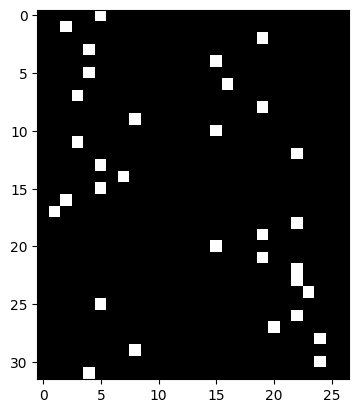

In [ ]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]), cmap='gray') # activation mask

In [27]:
db2.shape, b2.shape, logits.shape

(torch.Size([27]), torch.Size([27]), torch.Size([32, 27]))

In [35]:
bnvar_inv.shape

torch.Size([1, 64])

In [48]:
Xe = F.one_hot(Xb, num_classes = 27).float() # C[Xb] <=> Xe @ C
dC = (Xe.permute(0, 2, 1) @ demb).sum(0)
dC.shape

torch.Size([27, 10])

In [51]:
# manual backward pass
# dlogprobs = torch.zeros(logprobs.shape)
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = dlogprobs * (probs ** -1.0) # if probs is exactly 1 then dlogprobs will be backproped without any scaling, but if probs is less than 1 then dlogprobs will be scaled up (as a boosting factor)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
dcounts = dprobs * counts_sum_inv # waiting for the other branch of contribution to come in
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = dcounts * counts
dlogits = dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(1, keepdims=True)

# jasper implementation approx true
# dlogits2 = torch.zeros_like(dlogits)
# dlogits2[range(n), logits.max(1, keepdim=True).indices] = dlogit_maxes
# dlogits += dlogits2

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # broadcasted
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0) # keepdim=True)
dhpreact = (1.0 - h ** 2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5) ** -1.5 * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += (1.0/n) * torch.ones_like(dhprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0) # keepdim=True)
demb = dembcat.view(emb.shape)

# andrej implementation
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i, j]
        dC[ix] += demb[i, j]

# jasper implementation based on internet review
# Xe = F.one_hot(Xb, num_classes = 27).float() # C[Xb] <=> Xe @ C
# dC = (Xe.permute(0, 2, 1) @ demb).sum(0)
# or this one
# dC = torch.einsum('abc,abg->cg', F.one_hot(Xb, vocab_size).float(), demb)

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dhprebn', dhprebn, hprebn)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0
counts_sum      | exact: True  | approx: True  | maxdiff: 0.0
counts          | exact: True  | approx: True  | maxdiff: 0.0
norm_logits     | exact: True  | approx: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approx: True  | maxdiff: 0.0
logits          | exact: True  | approx: True  | maxdiff: 0.0
h               | exact: True  | approx: True  | maxdiff: 0.0
W2              | exact: True  | approx: True  | maxdiff: 0.0
b2              | exact: True  | approx: True  | maxdiff: 0.0
dhpreact        | exact: True  | approx: True  | maxdiff: 0.0
bngain          | exact: True  | approx: True  | maxdiff: 0.0
dbnraw          | exact: True  | approx: True  | maxdiff: 0.0
dbnbias         | exact: True  | approx: True  | maxdiff: 0.0
dbndiff         | exact: True  | approx: True  | maxdiff: 0.0
dbnvar_i

In [52]:
# Exercise 2

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.346835136413574 diff: 0.0


In [61]:
dlogits = F.softmax(logits, 1) # just take logits itself
dlogits[range(n), Yb] -= 1 # then subtract 1 from the target class
dlogits /= n # and divide by the batch size

cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approx: True  | maxdiff: 5.820766091346741e-09


In [67]:
F.softmax(logits, 1)[0]

tensor([0.0691, 0.0847, 0.0186, 0.0498, 0.0216, 0.0851, 0.0233, 0.0354, 0.0184,
        0.0322, 0.0339, 0.0343, 0.0359, 0.0300, 0.0376, 0.0140, 0.0096, 0.0180,
        0.0159, 0.0508, 0.0512, 0.0222, 0.0250, 0.0732, 0.0637, 0.0264, 0.0201],
       grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0] * n,  dlogits[0].sum() # think dlogits as a force

(tensor([ 0.0691,  0.0847,  0.0186,  0.0498,  0.0216,  0.0851,  0.0233,  0.0354,
         -0.9816,  0.0322,  0.0339,  0.0343,  0.0359,  0.0300,  0.0376,  0.0140,
          0.0096,  0.0180,  0.0159,  0.0508,  0.0512,  0.0222,  0.0250,  0.0732,
          0.0637,  0.0264,  0.0201], grad_fn=<MulBackward0>),
 tensor(-6.9849e-10, grad_fn=<SumBackward0>))

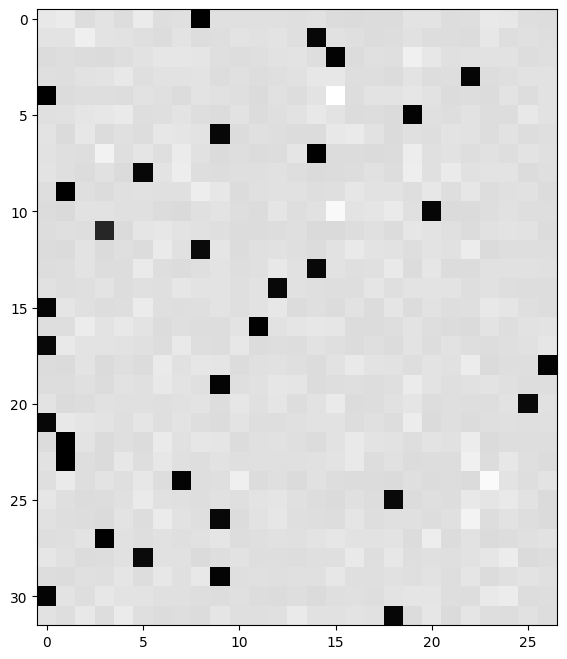

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach().numpy(), cmap='gray')

In [70]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [71]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8078
  10000/ 200000: 2.2131
  20000/ 200000: 2.3837
  30000/ 200000: 2.3863
  40000/ 200000: 1.9699
  50000/ 200000: 2.3579
  60000/ 200000: 2.4005
  70000/ 200000: 2.0409
  80000/ 200000: 2.3057
  90000/ 200000: 2.0876
 100000/ 200000: 1.9413
 110000/ 200000: 2.3190
 120000/ 200000: 2.0053
 130000/ 200000: 2.4330
 140000/ 200000: 2.4466
 150000/ 200000: 2.1860
 160000/ 200000: 2.0079
 170000/ 200000: 1.8056
 180000/ 200000: 2.0377
 190000/ 200000: 1.8851


In [72]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [73]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0691769123077393
val 2.109013557434082


In [74]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
reisha.
endra.
gradelynnelin.
shylopi.
eden.
sana.
arleigh.
malaia.
noshubergiaghiel.
kindreelynn.
novana.
ubekahdi.
jamyleyeks.
kayshayan.
daihan.
